In [86]:
import numpy as np
import os
import pickle
import cv2
import sys
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import time

In [87]:
def img_tointegral_img(image):
    s = np.zeros((image.shape[0],image.shape[1]))
    integral = np.zeros((image.shape[0],image.shape[1]))
    for i in range(len(image)):
        for j in range(len(image[0])):
            if(i-1 >=0):
                s[i][j] = s[i-1][j] + image[i][j]
            else:
                s[i][j] = image[i][j]
            if(j-1 >=0):
                integral[i][j] = integral[i][j-1] + s[i][j]
            else:
                integral[i][j] = s[i][j]
            
    return integral

In [88]:
def get_image_data(is_train):
    if(is_train == True):
        folder_name = 'trainset'
    else:
        folder_name = 'testset'
    
    faces_train = []
    for i in os.listdir('dataset/'+folder_name+'/faces/'):
        name = 'dataset/'+folder_name+'/faces/' + i
        image = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
        integral = img_tointegral_img(image)
        faces_train.append(integral)
    faces_train = np.array(faces_train)
    non_faces_train = []
    for i in os.listdir('dataset/'+folder_name+'/non-faces/'):
        name = 'dataset/'+folder_name+'/non-faces/' + i
        image = cv2.imread(name, cv2.IMREAD_GRAYSCALE)

        integral = img_tointegral_img(image)
        non_faces_train.append(integral)
    non_faces_train = np.array(non_faces_train)
    
    num_pos = len(faces_train)
    num_neg = len(non_faces_train)
    
    labels = []
    for i in range(num_pos):
        labels.append(1)
    for i in range(num_neg):
        labels.append(0)
    labels = np.array(labels)
    
    train_integral_data = []
    for i in faces_train:
        train_integral_data.append(i)
    for i in non_faces_train:
        train_integral_data.append(i)
    train_integral_data = np.array(train_integral_data)
    return (train_integral_data, labels)

In [10]:
train_input_data, train_labels = get_image_data(True)

In [11]:
test_input_data, test_labels = get_image_data(False)

In [12]:
train_input_data.shape, train_labels.shape

((2499, 19, 19), (2499,))

In [13]:
test_input_data.shape, test_labels.shape

((2473, 19, 19), (2473,))

In [89]:
def calc_value(x1,x2,x3,x4,integral):
    temp_sum = 0
    if(x4[0]>=0 and x4[1]>=0):
        temp_sum += integral[x4[0],x4[1]]
    if(x1[0]>=0 and x1[1]>=0):
        temp_sum += integral[x1[0],x1[1]]
    if(x2[0]>=0 and x2[1]>=0):
        temp_sum -= integral[x2[0],x2[1]]
    if(x3[0]>=0 and x3[1]>=0):
        temp_sum -= integral[x3[0],x3[1]]
    return temp_sum

In [90]:
cnt = 0
feature_index_feature_map = {}

In [91]:
def calc_features_feature_map(cnt,input_data):
    image = input_data[0]
    features1 = []
    for integral in input_data[:1]:
        sample = []
        for i in range(1,len(image)+1):
            for j in range(1,len(image[0])+1):
                for x in range(-1,len(image)):
                    for y in range(-1,len(image[0])):
                        x1 = [x,y]
                        x4 = [x+i,y+j]
                        x2 = [x,y+j]
                        x3 = [x+i,y]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f1_temp1 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x,y+j]
                        x4 = [x+i,y+2*j]
                        x2 = [x,y+2*j]
                        x3 = [x+i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f1_temp2 = calc_value(x1,x2,x3,x4,integral)
                        sample.append(-f1_temp1+f1_temp2)
                        feature_index_feature_map[cnt] = [1,i,j,x,y]
                        cnt += 1
        features1.append(sample)
    features1 = np.array(features1)
    
    features2 = []
    for integral in input_data[:1]:
        sample = []
        for i in range(1,len(image)+1):
            for j in range(1,len(image[0])+1):
                for x in range(-1,len(image)):
                    for y in range(-1,len(image[0])):
                        x1 = [x,y]
                        x4 = [x+i,y+j]
                        x2 = [x+i,y]
                        x3 = [x,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp1 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x+i,y]
                        x4 = [x+2*i,y+j]
                        x2 = [x+2*i,y]
                        x3 = [x+i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp2 = calc_value(x1,x2,x3,x4,integral)
                        sample.append(+f2_temp1-f2_temp2)
                        feature_index_feature_map[cnt] = [2,i,j,x,y]
                        cnt += 1
        features2.append(sample)
    features2 = np.array(features2)
    
    features3 = []
    for integral in input_data[:1]:
        sample = []
        for i in range(1,len(image)+1):
            for j in range(1,len(image[0])+1):
                for x in range(-1,len(image)):
                    for y in range(-1,len(image[0])):
                        x1 = [x,y]
                        x4 = [x+i,y+j]
                        x2 = [x,y+j]
                        x3 = [x+i,y]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f1_temp1 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x,y+j]
                        x4 = [x+i,y+2*j]
                        x2 = [x,y+2*j]
                        x3 = [x+i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        #print(x1,x2,x3,x4)
                        f1_temp2 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x,y+2*j]
                        x4 = [x+i,y+3*j]
                        x2 = [x,y+3*j]
                        x3 = [x+i,y+2*j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        #print(x1,x2,x3,x4)
                        f1_temp3 = calc_value(x1,x2,x3,x4,integral)
                        sample.append(+f1_temp1-f1_temp2+f1_temp3)
                        feature_index_feature_map[cnt] = [3,i,j,x,y]
                        cnt += 1
        features3.append(sample)
    features3 = np.array(features3)
    
    features4 = []
    for integral in input_data[:1]:
        sample = []
        for i in range(1,len(image)+1):
            for j in range(1,len(image[0])+1):
                for x in range(-1,len(image)):
                    for y in range(-1,len(image[0])):
                        x1 = [x,y]
                        x4 = [x+i,y+j]
                        x2 = [x+i,y]
                        x3 = [x,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp1 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x+i,y]
                        x4 = [x+2*i,y+j]
                        x2 = [x+2*i,y]
                        x3 = [x+i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp2 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x+2*i,y]
                        x4 = [x+3*i,y+j]
                        x2 = [x+3*i,y]
                        x3 = [x+2*i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp3 = calc_value(x1,x2,x3,x4,integral)
                        sample.append(+f2_temp1-f2_temp2+f2_temp3)
                        feature_index_feature_map[cnt] = [4,i,j,x,y]
                        cnt += 1
        features4.append(sample)
    features4 = np.array(features4)
    
    features5 = []
    for integral in input_data[:1]:
        sample = []
        for i in range(1,len(image)+1):
            for j in range(1,len(image[0])+1):
                for x in range(-1,len(image)):
                    for y in range(-1,len(image[0])):
                        x1 = [x,y]
                        x4 = [x+i,y+j]
                        x2 = [x+i,y]
                        x3 = [x,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp1 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x+i,y]
                        x4 = [x+2*i,y+j]
                        x2 = [x+2*i,y]
                        x3 = [x+i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp2 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x,y+j]
                        x4 = [x+i,y+2*j]
                        x2 = [x+i,y+j]
                        x3 = [x,y+2*j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp3 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x+i,y+j]
                        x4 = [x+2*i,y+2*j]
                        x2 = [x+i,y+2*j]
                        x3 = [x+2*i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp4 = calc_value(x1,x2,x3,x4,integral)
                        sample.append(-f2_temp1+f2_temp2+f2_temp3-f2_temp4)
                        feature_index_feature_map[cnt] = [5,i,j,x,y]
                        cnt += 1
        features5.append(sample)
    features5 = np.array(features5)
    
    total_features = np.concatenate([features1,features2,features3,features4,features5],axis=1)
    return total_features

In [17]:
calc_features_feature_map(0,train_input_data)

array([[1.400e+01, 1.000e+00, 2.000e+00, ..., 3.650e+02, 1.052e+03,
        4.520e+02]])

In [18]:
feature_types, feature_counts = np.unique(np.array(list(feature_index_feature_map.values()))[:,0],return_counts=True)

In [19]:
# Printing number of Haar features for Part 2.1

In [20]:
print("The total number of Haar Features is: %d."%(len(feature_index_feature_map)))
print("There are %d type 1 (two vertical) features."%(feature_counts[0]))
print("There are %d type 2 (two horizontal) features."%(feature_counts[1]))
print("There are %d type 3 (three horizontal) features."%(feature_counts[2]))
print("There are %d type 4 (three vertical) features."%(feature_counts[3]))
print("There are %d type 5 (four) features."%(feature_counts[4]))

The total number of Haar Features is: 63960.
There are 17100 type 1 (two vertical) features.
There are 17100 type 2 (two horizontal) features.
There are 10830 type 3 (three horizontal) features.
There are 10830 type 4 (three vertical) features.
There are 8100 type 5 (four) features.


In [96]:
def calc_features(input_data):
    image = input_data[0]
    features1 = []
    for integral in input_data:
        sample = []
        for i in range(1,len(image)+1):
            for j in range(1,len(image[0])+1):
                for x in range(-1,len(image)):
                    for y in range(-1,len(image[0])):
                        x1 = [x,y]
                        x4 = [x+i,y+j]
                        x2 = [x,y+j]
                        x3 = [x+i,y]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f1_temp1 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x,y+j]
                        x4 = [x+i,y+2*j]
                        x2 = [x,y+2*j]
                        x3 = [x+i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f1_temp2 = calc_value(x1,x2,x3,x4,integral)
                        sample.append(-f1_temp1+f1_temp2)

        features1.append(sample)
    features1 = np.array(features1)
    
    features2 = []
    for integral in input_data:
        sample = []
        for i in range(1,len(image)+1):
            for j in range(1,len(image[0])+1):
                for x in range(-1,len(image)):
                    for y in range(-1,len(image[0])):
                        x1 = [x,y]
                        x4 = [x+i,y+j]
                        x2 = [x+i,y]
                        x3 = [x,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp1 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x+i,y]
                        x4 = [x+2*i,y+j]
                        x2 = [x+2*i,y]
                        x3 = [x+i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp2 = calc_value(x1,x2,x3,x4,integral)
                        sample.append(+f2_temp1-f2_temp2)
        features2.append(sample)
    features2 = np.array(features2)
    
    features3 = []
    for integral in input_data:
        sample = []
        for i in range(1,len(image)+1):
            for j in range(1,len(image[0])+1):
                for x in range(-1,len(image)):
                    for y in range(-1,len(image[0])):
                        x1 = [x,y]
                        x4 = [x+i,y+j]
                        x2 = [x,y+j]
                        x3 = [x+i,y]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f1_temp1 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x,y+j]
                        x4 = [x+i,y+2*j]
                        x2 = [x,y+2*j]
                        x3 = [x+i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        #print(x1,x2,x3,x4)
                        f1_temp2 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x,y+2*j]
                        x4 = [x+i,y+3*j]
                        x2 = [x,y+3*j]
                        x3 = [x+i,y+2*j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        #print(x1,x2,x3,x4)
                        f1_temp3 = calc_value(x1,x2,x3,x4,integral)
                        sample.append(+f1_temp1-f1_temp2+f1_temp3)
        features3.append(sample)
    features3 = np.array(features3)
    
    features4 = []
    for integral in input_data:
        sample = []
        for i in range(1,len(image)+1):
            for j in range(1,len(image[0])+1):
                for x in range(-1,len(image)):
                    for y in range(-1,len(image[0])):
                        x1 = [x,y]
                        x4 = [x+i,y+j]
                        x2 = [x+i,y]
                        x3 = [x,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp1 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x+i,y]
                        x4 = [x+2*i,y+j]
                        x2 = [x+2*i,y]
                        x3 = [x+i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp2 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x+2*i,y]
                        x4 = [x+3*i,y+j]
                        x2 = [x+3*i,y]
                        x3 = [x+2*i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp3 = calc_value(x1,x2,x3,x4,integral)
                        sample.append(+f2_temp1-f2_temp2+f2_temp3)
        features4.append(sample)
    features4 = np.array(features4)
    
    features5 = []
    for integral in input_data:
        sample = []
        for i in range(1,len(image)+1):
            for j in range(1,len(image[0])+1):
                for x in range(-1,len(image)):
                    for y in range(-1,len(image[0])):
                        x1 = [x,y]
                        x4 = [x+i,y+j]
                        x2 = [x+i,y]
                        x3 = [x,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp1 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x+i,y]
                        x4 = [x+2*i,y+j]
                        x2 = [x+2*i,y]
                        x3 = [x+i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp2 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x,y+j]
                        x4 = [x+i,y+2*j]
                        x2 = [x+i,y+j]
                        x3 = [x,y+2*j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp3 = calc_value(x1,x2,x3,x4,integral)
                        x1 = [x+i,y+j]
                        x4 = [x+2*i,y+2*j]
                        x2 = [x+i,y+2*j]
                        x3 = [x+2*i,y+j]
                        if(x4[0]>=len(image) or x4[1]>=len(image[0])):
                            continue
                        f2_temp4 = calc_value(x1,x2,x3,x4,integral)
                        sample.append(-f2_temp1+f2_temp2+f2_temp3-f2_temp4)
        features5.append(sample)
    features5 = np.array(features5)
    
    total_features = np.concatenate([features1,features2,features3,features4,features5],axis=1)
    return total_features

In [19]:
train_features = calc_features(train_input_data)

In [20]:
np.save('train_features.npy',train_features)
np.save('train_labels.npy',train_labels)

In [21]:
test_features = calc_features(test_input_data)

In [22]:
np.save('test_features.npy',test_features)
np.save('test_labels.npy',test_labels)

In [23]:
# loading train and test data

In [92]:
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')

In [93]:
test_features = np.load('test_features.npy')
test_labels = np.load('test_labels.npy')

In [94]:
train_features.shape, test_features.shape

((2499, 63960), (2473, 63960))

In [95]:
# Initializing weights

In [97]:
num_pos = np.sum(train_labels)
num_neg = len(train_labels) - num_pos

In [98]:
weights = []
for i in range(num_pos):
    weights.append(1/float(2*num_pos))
for i in range(num_neg):
    weights.append(1/float(2*num_neg))
weights = np.array(weights)
weights = weights/np.sum(weights)

In [99]:
def weak_classifier(image_index,feature_index,threshold,polarity,is_train):
    if(is_train==True):
        if(polarity*train_features[image_index,feature_index] <  polarity*threshold):
            return 1
        else:
            return 0
    else:
        if(polarity*test_features[image_index,feature_index] <  polarity*threshold):
            return 1
        else:
            return 0

In [100]:
def one_round(weights):
    t_pos = 0
    t_neg = 0
    for i in range(len(train_labels)):
        if(train_labels[i]==1):
            t_pos += weights[i]
        else:
            t_neg += weights[i]
        
    all_clfs = []
    for feature_index in range(train_features.shape[1]):
        
        feature_values = train_features[:,feature_index]
        sorted_feature_value_indices = np.argsort(feature_values)
        s_pos = 0
        s_neg = 0
        weights_pos_till_now,weights_neg_till_now = 0, 0
        values = [sys.maxsize,0,0] # error,feature_threshold,feature_polarity
        for i in sorted_feature_value_indices:
            cur_error = min(weights_neg_till_now+t_pos-weights_pos_till_now,weights_pos_till_now+t_neg-weights_neg_till_now)
            if(cur_error<values[0]):
                values[0] = cur_error
                values[1] = feature_values[i]
                if(s_pos > s_neg):
                    values[2] = 1
                else:
                    values[2] = -1
            if(train_labels[i]==1):
                s_pos += 1
                weights_pos_till_now += weights[i]
            else:
                s_neg += 1
                weights_neg_till_now += weights[i]
        all_clfs.append([feature_index,values[1],values[2]])
    
    best_clf_index,best_err = 0,sys.maxsize
    for clf_index,clf in enumerate(all_clfs):
        
        cur_err = 0
        for i in range(train_features.shape[0]):
            if(weak_classifier(i,clf[0],clf[1],clf[2],True)!=train_labels[i]):
                cur_err += weights[i]
        cur_err = cur_err/float(train_features.shape[0])
        if(cur_err < best_err):
            best_clf_index,best_err = clf_index, cur_err      
    return all_clfs[best_clf_index], best_err

In [169]:
start_time = time.time()

rounds = []
for each_round in range(10):
    print(each_round)
    clf, error = one_round(weights)
    beta = error / float(1-error)
    for i in range(train_features.shape[0]):
        if(weak_classifier(i,clf[0],clf[1],clf[2],True)==train_labels[i]):
            weights[i] = weights[i] * (beta)
    weights = weights/np.sum(weights)
    alpha = np.log(1/float(beta))
    print(clf,alpha)
    rounds.append([clf,alpha])
    
end_time = time.time()

0
[10142, 106.0, -1] 9.962126797991662
1
[10554, 386.0, -1] 10.007012923023083
2
[58239, 38.0, -1] 15.363318089056966
3
[58598, 23.0, -1] 9.959563133069697
4
[19688, -85.0, 1] 10.50054765042498
5
[22212, 68.0, -1] 15.707706220080317
6
[20342, 398.0, -1] 13.946431643690248
7
[10727, -23.0, -1] 16.486412541341522
8
[56430, 46.0, -1] 14.605886294781463
9
[1288, -63.0, -1] 15.980638481093377


In [170]:
rounds_arr = np.array(rounds)

In [171]:
print("Total time taken in seconds:",end_time-start_time)

Total time taken in seconds: 4387.519892215729


In [35]:
with open('rounds_arr.pickle', 'wb') as handle:
    pickle.dump(rounds_arr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [101]:
with open('rounds_arr.pickle', 'rb') as handle:
    rounds_arr = pickle.load(handle)

In [102]:
rounds_arr

array([[list([10142, 106.0, -1]), 9.962126797991662],
       [list([10554, 386.0, -1]), 10.007012923023083],
       [list([58239, 38.0, -1]), 15.363318089056966],
       [list([58598, 23.0, -1]), 9.959563133069697],
       [list([19688, -85.0, 1]), 10.50054765042498],
       [list([22212, 68.0, -1]), 15.707706220080317],
       [list([20342, 398.0, -1]), 13.946431643690248],
       [list([10727, -23.0, -1]), 16.486412541341522],
       [list([56430, 46.0, -1]), 14.605886294781463],
       [list([1288, -63.0, -1]), 15.980638481093377]], dtype=object)

In [103]:
def strong_clf(image_index,num_rounds,is_train):
    total = 0
    for round_index in range(num_rounds):
        if(weak_classifier(image_index,rounds_arr[round_index][0][0],rounds_arr[round_index][0][1],rounds_arr[round_index][0][2],is_train)==1):
            total += rounds_arr[round_index][1]
    if(total>= 0.5*sum(rounds_arr[:num_rounds,1])):
        return 1
    else:
        return 0

In [107]:
training_acc = []
for desired_value in range(1,11):
    cur_acc = 0
    num_rounds = desired_value
    for i in range(train_features.shape[0]):
        if(strong_clf(i,num_rounds,True)==train_labels[i]):
            cur_acc += 1
    cur_acc = cur_acc
    print('Training acc for round %d is: %f,%f'%(desired_value,cur_acc,cur_acc/float(len(train_labels))))
    training_acc.append(cur_acc/float(len(train_labels)))

Training acc for round 1 is: 2145.000000,0.858343
Training acc for round 2 is: 1950.000000,0.780312
Training acc for round 3 is: 2166.000000,0.866747
Training acc for round 4 is: 2068.000000,0.827531
Training acc for round 5 is: 2242.000000,0.897159
Training acc for round 6 is: 2173.000000,0.869548
Training acc for round 7 is: 2317.000000,0.927171
Training acc for round 8 is: 2264.000000,0.905962
Training acc for round 9 is: 2346.000000,0.938776
Training acc for round 10 is: 2261.000000,0.904762


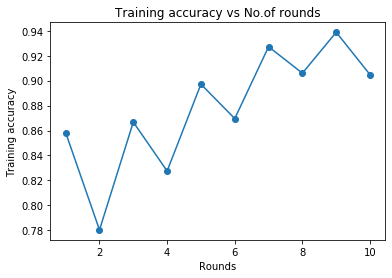

In [112]:
plt.plot(range(1,11),training_acc,'-o')
plt.xlabel('Rounds')
plt.ylabel('Training accuracy')
plt.title('Training accuracy vs No.of rounds')
plt.show()

In [116]:
training_fp = []
for desired_value in range(1,11):
    fp = 0
    tn = 0
    num_rounds = desired_value
    for i in range(train_features.shape[0]):
        if(train_labels[i]==0):
            tn += 1
            if(strong_clf(i,num_rounds,True)==1):
                fp += 1
    fpr = fp/float(train_features.shape[0])
    print('Training Fasle Postive Rate::',fpr,fp)
    training_fp.append(fpr)

Training Fasle Postive Rate:: 0.12605042016806722 315
Training Fasle Postive Rate:: 0.09643857543017206 241
Training Fasle Postive Rate:: 0.09003601440576231 225
Training Fasle Postive Rate:: 0.12765106042416965 319
Training Fasle Postive Rate:: 0.045218087234893956 113
Training Fasle Postive Rate:: 0.09083633453381353 227
Training Fasle Postive Rate:: 0.026810724289715888 67
Training Fasle Postive Rate:: 0.08443377350940376 211
Training Fasle Postive Rate:: 0.022408963585434174 56
Training Fasle Postive Rate:: 0.07683073229291716 192


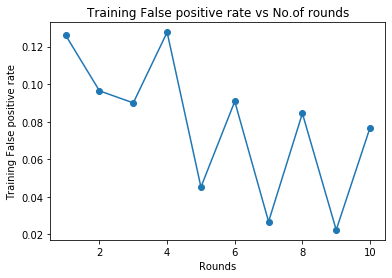

In [118]:
plt.plot(range(1,11),training_fp,'-o')
plt.xlabel('Rounds')
plt.ylabel('Training False positive rate')
plt.title('Training False positive rate vs No.of rounds')
plt.show()

In [117]:
training_fn = []
for desired_value in range(1,11):
    fn = 0
    tp = 0
    num_rounds = desired_value
    for i in range(train_features.shape[0]):
        if(train_labels[i]==1):
            tp += 1
            if(strong_clf(i,num_rounds,True)==0):
                fn += 1
    fnr = fn/float(train_features.shape[0])
    print('Training Fasle Negative Rate::',fnr,fn)
    training_fn.append(fnr)

Training Fasle Negative Rate:: 0.015606242496998799 39
Training Fasle Negative Rate:: 0.12324929971988796 308
Training Fasle Negative Rate:: 0.04321728691476591 108
Training Fasle Negative Rate:: 0.04481792717086835 112
Training Fasle Negative Rate:: 0.057623049219687875 144
Training Fasle Negative Rate:: 0.03961584633853541 99
Training Fasle Negative Rate:: 0.04601840736294518 115
Training Fasle Negative Rate:: 0.009603841536614645 24
Training Fasle Negative Rate:: 0.038815526210484196 97
Training Fasle Negative Rate:: 0.01840736294517807 46


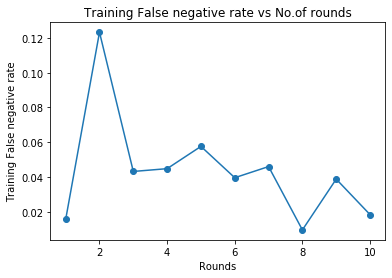

In [119]:
plt.plot(range(1,11),training_fn,'-o')
plt.xlabel('Rounds')
plt.ylabel('Training False negative rate')
plt.title('Training False negative rate vs No.of rounds')
plt.show()

In [122]:
testing_acc = []
for desired_value in range(1,11):
    cur_acc = 0
    num_rounds = desired_value
    for i in range(test_features.shape[0]):
        if(strong_clf(i,num_rounds,False)==test_labels[i]):
            cur_acc += 1
    cur_acc = cur_acc
    print('Testing acc:',cur_acc,cur_acc/float(len(test_labels)))
    testing_acc.append(cur_acc/float(len(test_labels)))

Testing acc: 1943 0.7856854023453296
Testing acc: 1840 0.7440355843105539
Testing acc: 1933 0.7816417306914678
Testing acc: 1918 0.7755762232106753
Testing acc: 1964 0.7941771128184392
Testing acc: 1989 0.8042862919530934
Testing acc: 1996 0.8071168621107966
Testing acc: 1970 0.7966033158107562
Testing acc: 1999 0.8083299636069551
Testing acc: 1961 0.7929640113222807


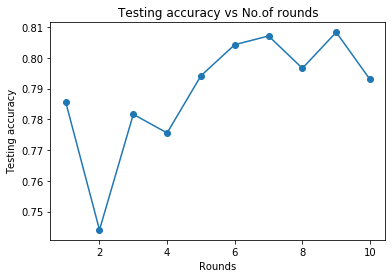

In [126]:
plt.plot(range(1,11),testing_acc,'-o')
plt.xlabel('Rounds')
plt.ylabel('Testing accuracy')
plt.title('Testing accuracy vs No.of rounds')
plt.show()

In [123]:
testing_fp = []
for desired_value in range(1,11):
    fp = 0
    tn = 0
    num_rounds = desired_value
    for i in range(test_features.shape[0]):
        if(test_labels[i]==0):
            tn += 1
            if(strong_clf(i,num_rounds,False)==1):
                fp += 1
    fpr = fp/float(len(test_labels))
    print('Testing Fasle Postive Rate::',fpr,fp)
    testing_fp.append(fpr)

Testing Fasle Postive Rate:: 0.07278608976951072 180
Testing Fasle Postive Rate:: 0.08249090173877881 204
Testing Fasle Postive Rate:: 0.04852405984634048 120
Testing Fasle Postive Rate:: 0.06429437929640114 159
Testing Fasle Postive Rate:: 0.029114435907804288 72
Testing Fasle Postive Rate:: 0.03962798220784472 98
Testing Fasle Postive Rate:: 0.014961585119288313 37
Testing Fasle Postive Rate:: 0.05054589567327133 125
Testing Fasle Postive Rate:: 0.010917913465426607 27
Testing Fasle Postive Rate:: 0.04892842701172665 121


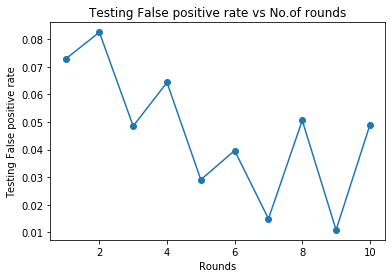

In [127]:
plt.plot(range(1,11),testing_fp,'-o')
plt.xlabel('Rounds')
plt.ylabel('Testing False positive rate')
plt.title('Testing False positive rate vs No.of rounds')
plt.show()

In [125]:
testing_fn = []
for desired_value in range(1,11):
    fn = 0
    tp = 0
    num_rounds = desired_value
    for i in range(test_features.shape[0]):
        if(test_labels[i]==1):
            tp += 1
            if(strong_clf(i,num_rounds,False)==0):
                fn += 1
    fnr = fn/float(len(test_labels))
    print('Testing Fasle Negative Rate::',fnr,fn)
    testing_fn.append(fnr)

Testing Fasle Negative Rate:: 0.14152850788515972 350
Testing Fasle Negative Rate:: 0.1734735139506672 429
Testing Fasle Negative Rate:: 0.16983420946219166 420
Testing Fasle Negative Rate:: 0.16012939749292357 396
Testing Fasle Negative Rate:: 0.17670845127375656 437
Testing Fasle Negative Rate:: 0.15608572583906186 386
Testing Fasle Negative Rate:: 0.1779215527699151 440
Testing Fasle Negative Rate:: 0.1528507885159725 378
Testing Fasle Negative Rate:: 0.18075212292761828 447
Testing Fasle Negative Rate:: 0.1581075616659927 391


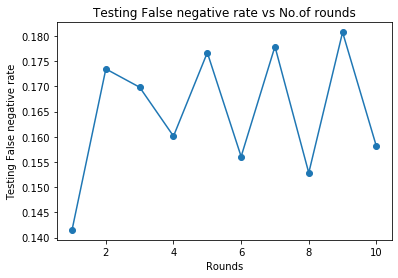

In [128]:
plt.plot(range(1,11),testing_fn,'-o')
plt.xlabel('Rounds')
plt.ylabel('Testing False negative rate')
plt.title('Testing False negative rate vs No.of rounds')
plt.show()

In [234]:
weak_classifier_acc = []
for clf_round in range(10):
    cur_acc = 0
    #num_rounds = desired_value
    for i in range(train_features.shape[0]):
        if(weak_classifier(i,rounds_arr[clf_round][0][0],rounds_arr[clf_round][0][1],rounds_arr[clf_round][0][2],True)==train_labels[i]):
            cur_acc += 1
    cur_acc = cur_acc/float(train_features.shape[0])
    print('weak classifier with round acc:',cur_acc)
    weak_classifier_acc.append(cur_acc)

weak classifier with round acc: 0.858343337334934
weak classifier with round acc: 0.78031212484994
weak classifier with round acc: 0.6846738695478192
weak classifier with round acc: 0.6650660264105642
weak classifier with round acc: 0.8147258903561424
weak classifier with round acc: 0.6802721088435374
weak classifier with round acc: 0.8467386954781913
weak classifier with round acc: 0.5898359343737495
weak classifier with round acc: 0.7827130852340937
weak classifier with round acc: 0.44337735094037617


In [47]:
# plotting features

In [42]:
def plot_feature(feature_index,image):
    feature_type,i,j,x,y = feature_index_feature_map[feature_index]
    temp_image = image.copy()
    if(feature_type == 1):
        temp_image[x+1:x+i+1,y+1:y+j+1] = 0
        temp_image[x+1:x+i+1,y+j+1:y+2*j+1] = 255
    if(feature_type == 2):
        temp_image[x+1:x+i+1,y+1:y+j+1] = 255
        temp_image[x+i+1:x+2*i+1,y+1:y+j+1] = 0
    if(feature_type == 3):
        temp_image[x+1:x+i+1,y+1:y+j+1] = 255
        temp_image[x+1:x+i+1,y+j+1:y+2*j+1] = 0
        temp_image[x+1:x+i+1,y+2*j+1:y+3*j+1] = 255
    if(feature_type == 4):
        temp_image[x+1:x+i+1,y+1:y+j+1] = 255
        temp_image[x+i+1:x+2*i+1,y+1:y+j+1] = 0
        temp_image[x+2*i+1:x+3*i+1,y+1:y+j+1] = 255
    if(feature_type == 5):
        temp_image[x+1:x+i+1,y+1:y+j+1] = 0
        temp_image[x+1:x+i+1,y+j+1:y+2*j+1] = 255
        temp_image[x+i+1:x+2*i+1,y+1:y+j+1] = 255
        temp_image[x+i+1:x+2*i+1,y+j+1:y+2*j+1] = 0
    return temp_image

In [43]:
plot_image = cv2.imread('dataset/testset/faces/cmu_0049.png', cv2.IMREAD_GRAYSCALE)

In [44]:
plot_image.shape

(19, 19)

In [45]:
rounds_arr

array([[list([10142, 106.0, -1]), 9.962126797991662],
       [list([10554, 386.0, -1]), 10.007012923023083],
       [list([58239, 38.0, -1]), 15.363318089056966],
       [list([58598, 23.0, -1]), 9.959563133069697],
       [list([19688, -85.0, 1]), 10.50054765042498],
       [list([22212, 68.0, -1]), 15.707706220080317],
       [list([20342, 398.0, -1]), 13.946431643690248],
       [list([10727, -23.0, -1]), 16.486412541341522],
       [list([56430, 46.0, -1]), 14.605886294781463],
       [list([1288, -63.0, -1]), 15.980638481093377]], dtype=object)

In [46]:
# Round 1

In [47]:
print("round 1 feature:",feature_index_feature_map[rounds_arr[0][0][0]])

round 1 feature: [1, 8, 1, 2, 7]


In [50]:
print("round 3 feature:",feature_index_feature_map[rounds_arr[2][0][0]])

round 3 feature: [5, 2, 3, 14, 4]


In [54]:
print("round 5 feature:",feature_index_feature_map[rounds_arr[4][0][0]])

round 5 feature: [2, 1, 10, 14, 7]


In [55]:
print("round 10 feature:",feature_index_feature_map[rounds_arr[9][0][0]])

round 10 feature: [1, 1, 5, 13, 7]


Text(0.5, 1.0, 'Top 1 feature for first round Adaboost')

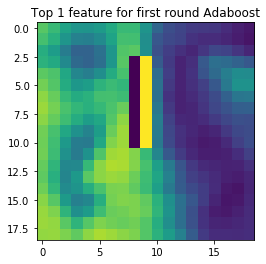

In [49]:
temp_plot_image = plot_feature(rounds_arr[0][0][0],plot_image)
imshow(temp_plot_image)
plt.title("Top 1 feature for first round Adaboost")

Text(0.5, 1.0, 'Top 1 feature for 3rd round Adaboost')

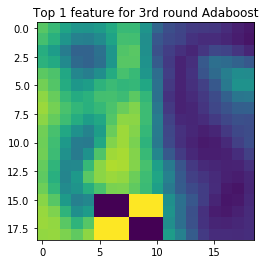

In [52]:
temp_plot_image = plot_feature(rounds_arr[2][0][0],plot_image)
imshow(temp_plot_image)
plt.title("Top 1 feature for 3rd round Adaboost")

Text(0.5, 1.0, 'Top 1 feature for 5th round Adaboost')

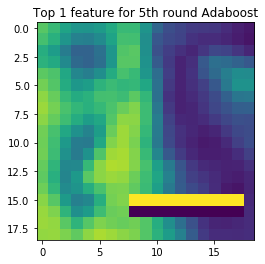

In [56]:
temp_plot_image = plot_feature(rounds_arr[4][0][0],plot_image)
imshow(temp_plot_image)
plt.title("Top 1 feature for 5th round Adaboost")

Text(0.5, 1.0, 'Top 1 feature for 10th round Adaboost')

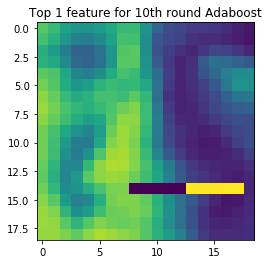

In [57]:
temp_plot_image = plot_feature(rounds_arr[9][0][0],plot_image)
imshow(temp_plot_image)
plt.title("Top 1 feature for 10th round Adaboost")